### Making Surface Productivity Movies 

In this notebook, I read in productivity, surface iron deposition, and local irradiance data from my model. I then read in 3d data (productivity) and make 2d output to create a movie with. 

In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
from eccoseas.downscale import vertical
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
from datetime import datetime, timedelta
import glob

In [85]:
# Define a path to this lesson's folder
# lesson_folder = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 14'
lesson_folder = '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2'

In [86]:
# define the parameters that will be used in the data file
XC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/XC720_540.bin', '>f8').reshape(720, 1)
#print(XC)
YC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/YC720_540.bin', '>f8').reshape(540, 1)
#print(YC)
delX = 3.595/720
delY = 1.078/540
xgOrigin = -52.8
ygOrigin = 63.8
n_rows = 540
n_cols = 720

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 9',
                                 'Greenland_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [87]:
depth = bathy
delR = np.array([1.00,    1.14,    1.30,    1.49,   1.70,
          1.93,    2.20,    2.50,    2.84,   3.21,
          3.63,    4.10,    4.61,    5.18,   5.79,
          6.47,    7.20,    7.98,    8.83,   9.73,
         10.69,   11.70,   12.76,   13.87,  15.03,
         16.22,   17.45,   18.70,   19.97,  21.27,
         22.56,   23.87,   25.17,   26.46,  27.74,
         29.00,   30.24,   31.45,   32.65,  33.82,
         34.97,   36.09,   37.20,   38.29,  39.37])
hfacC_file = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 13/hFacC.data'
hfacC = np.fromfile(hfacC_file, '>f4').reshape(45, 540, 720)
land_mask = (hfacC[0, :, :] == 0)   # True = land/dry, False = ocean

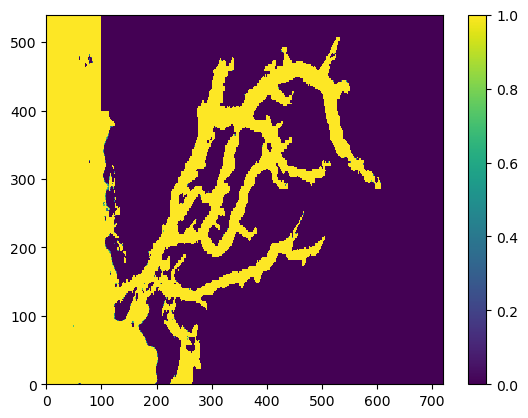

In [88]:
plt.pcolormesh(hfacC[10,:,:], vmax = 1)
plt.colorbar()

In [89]:
# testing a code block that reads the iter_step from the files

ny = 540
nx = 720
nz = 45

def read_surface_productivity(lesson_folder):

    npp_list = [] # net primary production (sum of all columns) 
    chl_list = [] # surface chlorophyll
    psm_list = [] # surface small phyto
    plg_list = [] # surface large phyto
    fe_dep_list = [] # surface iron deposition
    irr_list = [] # surface irradiance
    iter_list = [] 

    # reading in all productivity files 
    productivity_dir = os.path.join(lesson_folder, 'bling', 'productivity')
    fe_dep_dir = os.path.join(lesson_folder, 'bling', 'fe_dep')
    irr_dir = os.path.join(lesson_folder, 'bling', 'irradiance')
    
    # glob finds all output files for this diagnostic (*.data) so we can loop through timesteps 
    productivity_files = sorted(glob.glob(os.path.join(productivity_dir, "*.data")))

    for prod_file in productivity_files:
        # get the iteration number from the filename
        iter_str = os.path.basename(prod_file).split(".")[-2]
        i = int(iter_str)

        # here i read in the correct value to each productivity variable (3d)
        prod_data = np.fromfile(prod_file, ">f4").reshape(4, nz, ny, nx)
        NPP_3d = prod_data[0]
        CHL_3d = prod_data[1]
        PSM_3d = prod_data[2]
        PLG_3d = prod_data[3]

        # now i'm taking the 3d files and making them 2d since i want to make movies of SURFACE productivity 
        # NPP is the exception - i'm actually summing the entire water column for this variable 
        
        NPP_sum  = np.sum(NPP_3d, axis=0)
        CHL_surf = CHL_3d[0,:,:]
        PSM_surf = PSM_3d[0,:,:]
        PLG_surf = PLG_3d[0,:,:]

        # now reading in surface iron deposition (2d)
        fe_dep_file = os.path.join(lesson_folder, "bling", "fe_dep", f"fe_dep.{iter_str}.data")

        if not os.path.isfile(fe_dep_file):
            print(f"Skipping {i}: FE file missing")
            continue

        FE_dep = np.fromfile(fe_dep_file, ">f4").reshape(ny, nx)

        # now reading in local irradiance (3d) 
        irr_file = os.path.join(lesson_folder, "bling", "irradiance", f"irradiance.{iter_str}.data")

        if not os.path.isfile(irr_file):
            print(f"Skipping {i}: irradiance file missing")
            continue

        # here i'm only taking the surface irradiance (2d)
        IRR = np.fromfile(irr_file, ">f4").reshape(nz, ny, nx)
        IRR_surf = IRR[0,:,:]

        # appending the lists made earlier 
        npp_list.append(NPP_sum)
        chl_list.append(CHL_surf)
        psm_list.append(PSM_surf)
        plg_list.append(PLG_surf)
        fe_dep_list.append(FE_dep)
        irr_list.append(IRR_surf)
        iter_list.append(i)

    # turn the lists into arrays
    NPP      = np.array(npp_list)
    CHL_SURF = np.array(chl_list)
    PSM_SURF = np.array(psm_list)
    PLG_SURF = np.array(plg_list)
    FE_DEP   = np.array(fe_dep_list)
    IRR_SURF = np.array(irr_list)
    iters    = np.array(iter_list)

    return NPP, CHL_SURF, PSM_SURF, PLG_SURF, FE_DEP, IRR_SURF, iters


# calling the function 
NPP, CHL_SURF, PSM_SURF, PLG_SURF, FE_DEP, IRR_SURF, prod_iters = read_surface_productivity(lesson_folder)


# test for sanity check
print("NPP shape:", NPP.shape)
print("CHL_SURF shape:", CHL_SURF.shape)
print("PSM_SURF shape:", PSM_SURF.shape)
print("PLG_SURF shape:", PLG_SURF.shape)
print("FE_DEP shape:", FE_DEP.shape)
print("IRR_SURF shape:", IRR_SURF.shape)
print("Iterations:", prod_iters[:5], "...", prod_iters[-5:])


NPP shape: (303, 540, 720)
CHL_SURF shape: (303, 540, 720)
PSM_SURF shape: (303, 540, 720)
PLG_SURF shape: (303, 540, 720)
FE_DEP shape: (303, 540, 720)
IRR_SURF shape: (303, 540, 720)
Iterations: [64440 65160 65880 66600 67320] ... [279000 279720 280440 281160 281880]


In [90]:
# here i'm seeing the max and min for each variable so i can plot them accordingly 

t = 0
print("NPP min/max:", NPP[t].min(), NPP[t].max())
print("CHL min/max:", CHL_SURF[t].min(), CHL_SURF[t].max())
print("PSM min/max:", PSM_SURF[t].min(), PSM_SURF[t].max())
print("PLG min/max:", PLG_SURF[t].min(), PLG_SURF[t].max())
print("FE min/max:", FE_DEP[t].min(), FE_DEP[t].max())
print("IRR min/max:", IRR_SURF[t].min(), IRR_SURF[t].max())


NPP min/max: 0.0 2.6162968
CHL min/max: 0.0 266699890.0
PSM min/max: 0.0 39.35799
PLG min/max: 0.0 479043900.0
FE min/max: 0.0 1e-13
IRR min/max: 0.0 4.0294456


In [97]:
# create a directory called 'plots' to put the following new files and movies into

plots_dir = os.path.join(lesson_folder, 'bling', 'plots')
os.makedirs(plots_dir, exist_ok=True)

In [116]:
# NPP movie:

deltaT = 30  # seconds per timestep
start_datetime = datetime(2017, 1, 1)

NPP_file_list = []
num_timesteps = NPP.shape[0]

for n in range(num_timesteps):

    # read in iteration and print out model time in yyyy/mm/dd format onto the plot
    iteration = prod_iters[n]
    model_seconds = int(iteration * deltaT)
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')
   
    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f"NPP_{iteration_str}.png")

    # mask the land 
    NPP_frame = NPP[n, :, :]
    NPP_masked = np.ma.masked_where(land_mask, NPP_frame)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(NPP_masked, cmap='turbo', vmin=0, vmax=7e-4)
    plt.colorbar(label='∑ NPP (mol C/m3/s)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Net Primary Production (summed) – {date_str}')

    plt.savefig(image_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    NPP_file_list.append(image_path)

print("Number of frames:", len(file_list))

Number of frames: 107
First few frames: ['/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000064440.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065160.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065880.png']


In [120]:
fps = 5
clip = ImageSequenceClip(NPP_file_list, fps=fps)

output_file = os.path.join(plots_dir,'NPP.mp4')

clip.write_videofile(
    output_file,
    codec="libx264",
    audio=False,
    ffmpeg_params=[
        "-pix_fmt", "yuv420p",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2"])


Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP.mp4


In [101]:
# CHL movie:

deltaT = 30  # seconds per timestep
start_datetime = datetime(2017, 1, 1)

CHL_file_list = []
num_timesteps = CHL_SURF.shape[0]

for n in range(num_timesteps):

    # read in iteration and print out model time in yyyy/mm/dd format onto the plot
    iteration = prod_iters[n]
    model_seconds = int(iteration * deltaT)
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')
   
    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f"CHL_{iteration_str}.png")

    # mask the land 
    CHL_frame = CHL_SURF[n, :, :]
    CHL_masked = np.ma.masked_where(land_mask, CHL_frame)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(CHL_masked, cmap='turbo', vmin=0, vmax=5)
    plt.colorbar(label='CHL Concentration (mg/m3)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Surface Chlorophyll Concentration – {date_str}')

    plt.savefig(image_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    CHL_file_list.append(image_path)

print("Number of frames:", len(file_list))

Number of frames: 107
First few frames: ['/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000064440.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065160.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065880.png']


In [102]:
fps = 5
clip = ImageSequenceClip(CHL_file_list, fps=fps)

output_file = os.path.join(plots_dir,'CHL.mp4')

clip.write_videofile(
    output_file,
    codec="libx264",
    audio=False,
    ffmpeg_params=[
        "-pix_fmt", "yuv420p",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2"])

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/CHL.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/CHL.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/CHL.mp4


In [103]:
# PSM movie:

deltaT = 30  # seconds per timestep
start_datetime = datetime(2017, 1, 1)

PSM_file_list = []
num_timesteps = PSM_SURF.shape[0]

for n in range(num_timesteps):

    # read in iteration and print out model time in yyyy/mm/dd format onto the plot
    iteration = prod_iters[n]
    model_seconds = int(iteration * deltaT)
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')
   
    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f"PSM_{iteration_str}.png")

    # mask the land 
    PSM_frame = PSM_SURF[n, :, :]
    PSM_masked = np.ma.masked_where(land_mask, PSM_frame)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(PSM_masked, cmap='turbo', vmin=0, vmax=3)
    plt.colorbar(label='Small phytoplankton biomass (mol C/m3/s)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Surface Small phytoplankton biomass – {date_str}')

    plt.savefig(image_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    PSM_file_list.append(image_path)

print("Number of frames:", len(file_list))

Number of frames: 107
First few frames: ['/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000064440.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065160.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065880.png']


In [104]:
fps = 5
clip = ImageSequenceClip(PSM_file_list, fps=fps)

output_file = os.path.join(plots_dir,'PSM.mp4')

clip.write_videofile(
    output_file,
    codec="libx264",
    audio=False,
    ffmpeg_params=[
        "-pix_fmt", "yuv420p",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2"])

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/PSM.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/PSM.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/PSM.mp4


In [105]:
# PLG movie:

deltaT = 30  # seconds per timestep
start_datetime = datetime(2017, 1, 1)

PLG_file_list = []
num_timesteps = PLG_SURF.shape[0]

for n in range(num_timesteps):

    # read in iteration and print out model time in yyyy/mm/dd format onto the plot
    iteration = prod_iters[n]
    model_seconds = int(iteration * deltaT)
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')
   
    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f"PLG_{iteration_str}.png")

    # mask the land 
    PLG_frame = PLG_SURF[n, :, :]
    PLG_masked = np.ma.masked_where(land_mask, PLG_frame)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(PLG_masked, cmap='turbo', vmin=0, vmax=0.05)
    plt.colorbar(label='Large phytoplankton biomass (mol C/m3/s)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Surface Large phytoplankton biomass – {date_str}')

    plt.savefig(image_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    PLG_file_list.append(image_path)

print("Number of frames:", len(file_list))

Number of frames: 107
First few frames: ['/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000064440.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065160.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065880.png']


In [106]:
fps = 5
clip = ImageSequenceClip(PLG_file_list, fps=fps)

output_file = os.path.join(plots_dir,'PLG.mp4')

clip.write_videofile(
    output_file,
    codec="libx264",
    audio=False,
    ffmpeg_params=[
        "-pix_fmt", "yuv420p",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2"])

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/PLG.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/PLG.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/PLG.mp4


In [107]:
# FE_DEP movie:

deltaT = 30  # seconds per timestep
start_datetime = datetime(2017, 1, 1)

FE_DEP_file_list = []
num_timesteps = PLG_SURF.shape[0]

for n in range(num_timesteps):

    # read in iteration and print out model time in yyyy/mm/dd format onto the plot
    iteration = prod_iters[n]
    model_seconds = int(iteration * deltaT)
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')
   
    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f"FE_DEP_{iteration_str}.png")

    # mask the land 
    FE_DEP_frame = FE_DEP[n, :, :]
    FE_DEP_masked = np.ma.masked_where(land_mask, FE_DEP_frame)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(FE_DEP_masked, cmap='turbo', vmin=0, vmax=1e-13)
    plt.colorbar(label='Surface deposition of Fe (mol/m2/s)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Surface deposition of Iron – {date_str}')

    plt.savefig(image_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    FE_DEP_file_list.append(image_path)

print("Number of frames:", len(file_list))

Number of frames: 107
First few frames: ['/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000064440.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065160.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065880.png']


In [108]:
fps = 5
clip = ImageSequenceClip(FE_DEP_file_list, fps=fps)

output_file = os.path.join(plots_dir,'FE_DEP.mp4')

clip.write_videofile(
    output_file,
    codec="libx264",
    audio=False,
    ffmpeg_params=[
        "-pix_fmt", "yuv420p",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2"])

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/FE_DEP.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/FE_DEP.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/FE_DEP.mp4


In [118]:
# IRR movie:

deltaT = 30  # seconds per timestep
start_datetime = datetime(2017, 1, 1)

IRR_SURF_file_list = []
num_timesteps = IRR_SURF.shape[0]

for n in range(num_timesteps):

    # read in iteration and print out model time in yyyy/mm/dd format onto the plot
    iteration = prod_iters[n]
    model_seconds = int(iteration * deltaT)
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')
   
    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f"IRR_SURF_{iteration_str}.png")

    # mask the land 
    IRR_SURF_frame = IRR_SURF[n, :, :]
    IRR_SURF_masked = np.ma.masked_where(land_mask, IRR_SURF_frame)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(IRR_SURF_masked, cmap='turbo', vmin=0, vmax=5)
    plt.colorbar(label='Surface irradiance (W/m2)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Surface irradiance – {date_str}')

    plt.savefig(image_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

    IRR_SURF_file_list.append(image_path)

print("Number of frames:", len(file_list))

Number of frames: 107
First few frames: ['/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000064440.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065160.png', '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/NPP_0000065880.png']


In [119]:
fps = 5
clip = ImageSequenceClip(IRR_SURF_file_list, fps=fps)

output_file = os.path.join(plots_dir,'IRR_SURF.mp4')

clip.write_videofile(
    output_file,
    codec="libx264",
    audio=False,
    ffmpeg_params=[
        "-pix_fmt", "yuv420p",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2"])

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/IRR_SURF.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/IRR_SURF.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/plots/IRR_SURF.mp4
